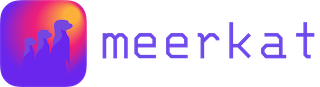


*What is `Meerkat`?*  `Meerkat` makes it easier for ML practitioners to interact with high-dimensional, multi-modal data. It provides simple abstractions for data inspection, model evaluation and model training supported by efficient and robust IO under the hood.

**Colab Runtime**: We recommend running this Colab with a GPU runtime. To change the runtime:
1. Click on `Runtime` on the top navigation bar.
2. Select `Change runtime type`.
3. Select `GPU` from the dropdown.

In [ ]:
!pip install git+https://github.com/robustness-gym/meerkat@dev

In [4]:
import logging
import os

import meerkat as mk
import numpy as np

## 💾 Downloading the data
First, we'll download some data to explore. We're going to use the [Imagenette dataset](https://github.com/fastai/imagenette#image%E7%BD%91), a small subset of the original [ImageNet](https://www.image-net.org/update-mar-11-2021.php).  This dataset is made up of 10 classes (e.g. "garbage truck", "gas pump", "golf ball").
- Download time: <1 minute
- Download size: 130M

In addition to downloading the data, `download_imagnette` prepares a CSV, `imagenette.csv`, with a row for each image. 

In [5]:
from meerkat.datasets.imagenette import download_imagenette

dataset_dir = "."
download_imagenette(dataset_dir)

Downloading:   0%|          | 0.00/99.0M [00:00<?, ?B/s]

Extracting tar archive, this may take a few minutes...


'./imagenette2-160'

## 📸 Creating an image `DataFrame`
Meerkat's core contribution is the DataFrame, a simple columnar data abstraction. The Meerkat DataFrame can house columns of arbitrary type – from integers and strings to complex, high-dimensional objects like videos, images, medical volumes and graphs.

We're going to build a `DataFrame` out of the `imagenette.csv` file from the download above.

,img_path (PandasSeriesColumn),label (PandasSeriesColumn),label_id (PandasSeriesColumn),label_idx (PandasSeriesColumn),split (PandasSeriesColumn),img (ImageColumn)
0,train/n02979186/n02979186_9036.JPEG,cassette player,n02979186,482,train,
1,train/n02979186/n02979186_11957.JPEG,cassette player,n02979186,482,train,
2,train/n02979186/n02979186_9715.JPEG,cassette player,n02979186,482,train,
3,train/n02979186/n02979186_21736.JPEG,cassette player,n02979186,482,train,
4,train/n02979186/ILSVRC2012_val_00046953.JPEG,cassette player,n02979186,482,train,

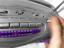
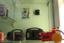
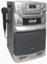
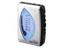
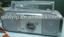

In [8]:
# Create a `DataFrame`
df = mk.DataFrame.from_csv("imagenette2-160/imagenette.csv")

# Create an `ImageColumn`` and add it to the `DataFrame`
df["img"] = mk.ImageColumn.from_filepaths(df["img_path"], base_dir="imagenette2-160")

df.head()

The call to `head` shows the first few rows in the `DataFrame`. You can see that there are a few metadata columns, as well as the "img" column we added in.

### 🗂 Indexing
When we create an `ImageColumn` we don't load the images into memory. Instead, `ImageColumn` keeps track of all those filepaths we passed in and only loads the images when they are accessed. 

Indexing the `ImageColumn` returns an object of type: <class 'PIL.Image.Image'>.


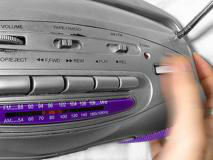

In [9]:
img = df["img"][0]
print(f"Indexing the `ImageColumn` returns an object of type: {type(img)}.")
display(img)

We can load a **batch** of images by indexing a slice. Notice that the output is a `ListColumn` of PIL images. 

In [10]:
imgs = df["img"][1:4]
print(f"Indexing a slice of the `ImageColumn` returns a: {type(imgs)}.")
display(imgs)

Indexing a slice of the `ImageColumn` returns a: <class 'meerkat.columns.list_column.ListColumn'>.


,(ListColumn)
0,
1,
2,


### 📎 _Aside_: `ImageColumn` under the hood, `LambdaColumn`.

If you check out the implementation of `ImageColumn` (at [meerkat/columns/image_column.py](https://github.com/robustness-gym/meerkat/blob/main/meerkat/columns/image_column.py)), you'll notice that it's a super simple subclass of `LambdaColumn`. 

_What's a `LambdaColumn`?_
In `meerkat`, high-dimensional data types like images and videos are typically stored in a `LambdaColumn`. A  `LambdaColumn` wraps around another column and lazily applies a function to it's content as it is indexed. Consider the following example, where we create a simple `meerkat` column...    
```
  >>> col = mk.NumpyArrayColumn([0,1,2])
  >>> col[0]
  0
```  
...and wrap it in a lambda column.
```
  >>> lambda_col = col.to_lambda(fn=lambda x: x + 10)
  >>> lambda_col[0]  # the function is only called at this point!
  10
```
Critically, the function inside a lambda column is only called at the time the column is indexed! This is very useful for columns with large data types that we don't want to load all into memory at once. For example, we could create a `LambdaColumn` that lazily loads images...
```
  >>> filepath_col = mk.PandasSeriesColumn(["path/to/image0.jpg", ...])
  >>> img_col = filepath.to_lambda
```
An `ImageColumn` is a just a `LambdaColumn` like this one, with a few more bells and whistles!


### 🦥 Lazy indexing.
What if we don't want to load the images? To access the underlying cell (without loading the image), use the lazy indexer, `lz`.

In [11]:
cell = df["img"][8000]
print(f"Lazy indexing the `ImageColumn` returns an object of type: {type(cell)}.")
display(cell)

Lazy indexing the `ImageColumn` returns an object of type: <class 'meerkat.columns.file_column.FileCell'>.


FileCell(fn=<meerkat.columns.file_column.FileLoader object at 0x17264c070>)

Note: **cells can survive on their own.** Everything we need to materialize the cell (e.g. the filepath to the image and the loading function) lives inside the cell, so we can call `cell.get()` to load the image even after the cell has been isolated from its original column. 

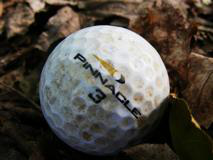

In [12]:
cell.get()

Using the lazy indexer and one of the following indexing schemes, we can also access a **subset** of a `LambdaColumn`, returning a smaller `LambdaColumn`.
- **Slice indexing**: _e.g._ `column[4:10]`
- **Integer array indexing**: _e.g._ `column[[0, 4, 6, 11]]`
- **Boolean array indexing**: _e.g._ `column[np.array([True, False, False ..., True, False])]`

Lazy indexing a slice of the `ImageColumn` returns an object of type: <class 'meerkat.columns.image_column.ImageColumn'>.


,(ImageColumn)
0,
1,
2,
3,

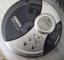
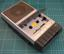
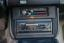

In [13]:
images = df["img"][12:16]
print(f"Lazy indexing a slice of the `ImageColumn` returns an object of type: {type(images)}.")
display(images)

## 🛠 Applying operations over the DataFrame.

When training and evaluating our models, we often perform operations on each example in our dataset (e.g. compute a model's prediction on each example, tokenize each sentence, compute a model's embedding for each example) and store them. The `DataFrame` makes it easy to perform these operations:  
- Produce new columns (via `DataFrame.map`)
- Produce new columns and store the columns alongside the original data (via `DataFrame.update`)
- Extract an important subset of the datset (via `DataFrame.filter`).   

Under the hood, dataloading is multiprocessed so that costly I/O doesn't bottleneck our computation.

Let's start by filtering the `DataFrame` down to the examples in the validation set. Note that we use the lazy indexer `lz` to avoid loading all of the images. 

In [14]:
valid_df = df[df["split"].data == "valid"]

### 🫐  Using `DataFrame.map` to compute average intensity of the blue color channel in the images.

To demonstrate the utility `map` operation, we'll explore the relationship between the "blueness" of an image and the class of the image. 

We'll quantify the "blueness" of each image by simply computing the mean intensity of the blue color channel. This can be accomplished with a simple `map` operation over the `DataFrame`:

In [15]:
blue_col = valid_df.map(
    lambda x: np.array(x["img"])[:, :, 2].mean(), 
    pbar=True, 
    num_workers=2
)

# Add the intensities as a new column in the `DataFrame` 
valid_df["avg_blue"] = blue_col

  0%|          | 0/3925 [00:00<?, ?it/s]

🪂 vs. ⛳️
Next, we'll explore the relationship between blueness and the class label of the image. To do so, we'll compare the blue intensity distribution of images labeled "parachute" to the distribution of of images labeled "golf ball".
Using the [`seaborn`](https://seaborn.pydata.org/installing.html) plotting package and our `DataFrame`, this can be accomplished in one line: 

In [16]:
!pip install seaborn

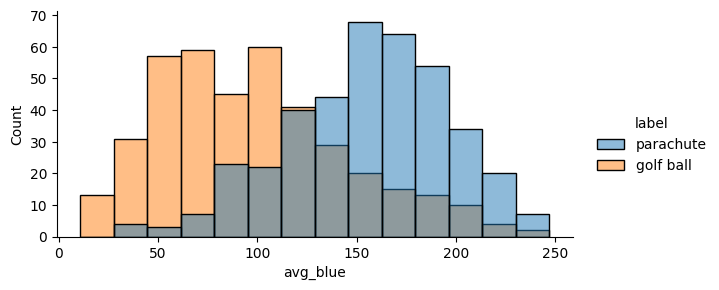

In [17]:
## OPTIONAL: this cell requires the seaborn dependency: https://seaborn.pydata.org/installing.html 
import seaborn as sns

plot_df = valid_df[np.isin(valid_df["label"], ["golf ball", "parachute"])]
sns.displot(
    data=plot_df.to_pandas(), 
    x="avg_blue", 
    hue="label", 
    height=3, 
    aspect=2
)

Looks like images of parachutes are quite a bit more blue than images of golf balls. To understand why this might be the case, we'll take a look at the image with the highest blue intensity:

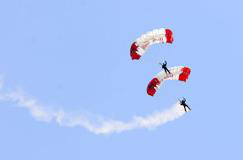

In [18]:
valid_df["img"][int(np.argmax(valid_df["avg_blue"]))]

Photos of parachutes usually have the sky behind them! Checks out that they're so blue...

## 📉 ML with images in `meerkat`.

Let's do some machine learning on our Imagenette `DataFrame`.
We'll take a resnet18 pretrained on the full ImageNet dataset, perform inference on the validation set, and analyze the model's predictions and activations. 

The cell below downloads the model.. 

In [19]:
import torch
from torchvision.models import resnet18
import torchvision.transforms as transforms
model = resnet18(pretrained=True)

/Users/sabrieyuboglu/opt/miniconda3/envs/meerkat/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/sabrieyuboglu/opt/miniconda3/envs/meerkat/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/sabrieyuboglu/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

### 💈  Creating an `ImageColumn` with a transform.
In order to do inference, we'll need to create a _new_ `ImageColumn`. The `ImageColumn` we defined above (_i.e._ `"img_path"`), does not apply any transforms after loading and simply returns a PIL image. Before passing the images through the model, we need to convert the PIL image to a `torch.Tensor` and normalize the color channels (along with a few other transformations). 

Note: the transforms defined below are the same as the ones used by torchvision, see [here](https://github.com/pytorch/examples/blob/cbb760d5e50a03df667cdc32a61f75ac28e11cbf/imagenet/main.py#L225). 

In the cell below, we specify a transform when creating the `ImageColumn`.

In [22]:
# Define transform
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]),
])

# Create new column with transform 
valid_df["input"] = mk.ImageColumn.from_filepaths(
    filepaths=valid_df["img_path"], 
    transform=transform,
    base_dir="imagenette2-160"
)

Notice that indexing this new `ImageColumn` returns a `torch.Tensor`, not a PIL image...  

In [23]:
img = valid_df["input"][0]
print(f"Indexing the `ImageColumn` returns an object of type: {type(img)}.")

Indexing the `ImageColumn` returns an object of type: <class 'torch.Tensor'>.


... and that indexing a slice of this new `ImageColumn` returns a `TensorColumn`, not a `ListColumn` of PIL images.

In [24]:
col = img = valid_df["input"][:3]
print(f"Indexing a slice of the `ImageColumn` returns an object of type: {type(img)}.")
display(col)

Indexing a slice of the `ImageColumn` returns an object of type: <class 'meerkat.columns.tensor_column.TensorColumn'>.


,(TensorColumn)
0,"torch.Tensor(shape=torch.Size([3, 224, 224]))"
1,"torch.Tensor(shape=torch.Size([3, 224, 224]))"
2,"torch.Tensor(shape=torch.Size([3, 224, 224]))"


Let's see what the full `DataFrame` looks like now.  

,img_path (PandasSeriesColumn),label (PandasSeriesColumn),label_id (PandasSeriesColumn),label_idx (PandasSeriesColumn),split (PandasSeriesColumn),img (ImageColumn),avg_blue (NumpyArrayColumn),input (ImageColumn)
0,val/n02979186/n02979186_8971.JPEG,cassette player,n02979186,482,valid,,185.601094,
1,val/n02979186/n02979186_14550.JPEG,cassette player,n02979186,482,valid,,62.194748,
2,val/n02979186/n02979186_11971.JPEG,cassette player,n02979186,482,valid,,130.1625,
3,val/n02979186/n02979186_11550.JPEG,cassette player,n02979186,482,valid,,32.186978,
4,val/n02979186/n02979186_8751.JPEG,cassette player,n02979186,482,valid,,57.249444,

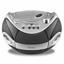
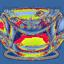
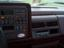
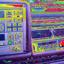
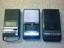
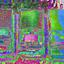
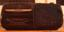
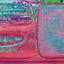
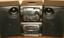
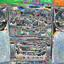

In [25]:
valid_df.head()

### 💫 Computing model predictions and activations.
We'd like to perform inference and extract:
  
1. Output predictions  
2. Output class probabilities  
3. Model activations 

Note: in order to extract model activations, we'll need to use a [PyTorch forward hook](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks) and register it on the final layer of the ResNet. Forward hooks are just functions that get executed on the forward pass of a `torch.nn.Module`. 

In [26]:
# Define forward hook in ActivationExtractor class
class ActivationExtractor:
    """Extracting activations a targetted intermediate layer"""

    def __init__(self):
        self.activation = None

    def forward_hook(self, module, input, output):
        self.activation = output

# Register forward hook
extractor = ActivationExtractor()
model.layer4.register_forward_hook(extractor.forward_hook);

We want to apply a forward pass to each image in the `DataFrame` and store the outputs as new columns: `DataFrame.update` is perfectly suited for this task. 

Like `map`, `update` accepts a function and applies it to batches of rows in the the `DataFrame`. Unlike `map`, `update` must return a dictionary. Each key in the dictionary corresponds to a new column that will be added to the updated `DataFrame`. 



In [30]:
# 1. Move the model to GPU, if available
# device = 0
device = "cpu"
model.to(device).eval()

# 2. Define a function that runs a forward pass over a batch 
@torch.no_grad()
def predict(batch: mk.DataFrame):
    input_col: mk.TensorColumn = batch["input"] 
    x: torch.Tensor = input_col.data.to(device)  # We get the underlying torch tensor with `data` and move to GPU 
    out: torch.Tensor = model(x)  # Run forward pass

    # Return a dictionary with one key for each of the new columns. Each value in the
    # dictionary should have the same length as the batch. 
    return {
        "pred": out.cpu().numpy().argmax(axis=-1),
        "probs": torch.softmax(out, axis=-1).cpu(),
        "activation": extractor.activation.mean(dim=[-1,-2]).cpu()
    }
# 3. Apply the update. Note that the `predict` function operates on batches, so we set 
# `batched=True`. Also, the `predict` function only accesses the "input" column, by 
# specifying that here we instruct update to only load that one column and skip others 
valid_df = valid_df.update(
    function=predict,
    is_batched_fn=True,
    batch_size=32,
    input_columns=["input"], 
    pbar=True
)

  0%|          | 0/123 [00:00<?, ?it/s]

The predictions, output probabilities, and activations are now stored alongside the examples in the `DataFrame`. 

In [ ]:
valid_df[["label_id", "input", "pred", "probs", "activation"]].head()

,label_id (NumpyArrayColumn),input (ImageColumn),pred (NumpyArrayColumn),probs (TensorColumn),activation (EmbeddingColumn),index (ListColumn)
0,n02979186,ImagePathCell(n02979186_8971.JPEG),482,torch.Tensor(shape=torch.Size([1000])),torch.Tensor(shape=torch.Size([512])),'9469'
1,n02979186,ImagePathCell(n02979186_14550.JPEG),754,torch.Tensor(shape=torch.Size([1000])),torch.Tensor(shape=torch.Size([512])),'9470'
2,n02979186,ImagePathCell(n02979186_11971.JPEG),482,torch.Tensor(shape=torch.Size([1000])),torch.Tensor(shape=torch.Size([512])),'9471'
3,n02979186,ImagePathCell(n02979186_11550.JPEG),482,torch.Tensor(shape=torch.Size([1000])),torch.Tensor(shape=torch.Size([512])),'9472'
4,n02979186,ImagePathCell(n02979186_8751.JPEG),482,torch.Tensor(shape=torch.Size([1000])),torch.Tensor(shape=torch.Size([512])),'9473'


### 🎯  Computing metrics and analyzing performance. 

Computing statistics on Meerkat `DataFrames` is straightforward because standard NumPy operators and functions can be applied directly to a `NumpyArrayColumn`. We take advantage of this below to compute the accuracy of the model.

In [34]:
valid_df["correct"] = valid_df["pred"] == valid_df["label_idx"].data
accuracy = valid_df["correct"].mean()
print(f"Micro accuracy across the ten Imagenette classes: {accuracy:0.3}")

Micro accuracy across the ten Imagenette classes: 0.672


In [35]:
valid_df["correct"]

,(PandasSeriesColumn)
0,True
1,False
2,True
3,True
4,True
...,...
3920,True
3921,False
3922,False
3923,True


Furthermore, since the `DataFrame` is naturally converted to a Pandas DataFrame, it's easy to use data visualization tools that interface with Pandas (_e.g._ seaborn, bokeh).

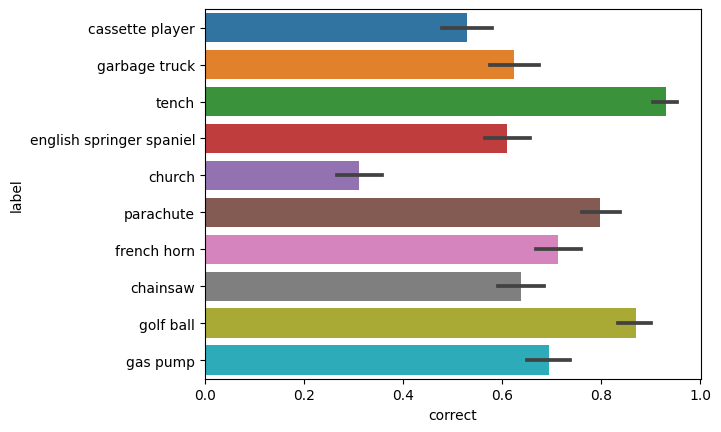

In [36]:
## OPTIONAL: this cell requires the seaborn dependency: https://seaborn.pydata.org/installing.html 
import seaborn as sns
import matplotlib.pyplot as plt
sns.barplot(data=valid_df.to_pandas(), y="label", x="correct");

### 🔎  Exploring model activations.
To better understand the behavior of our model, we'll explore the activations of the final convolutional layer of the ResNet. Recall that when we performed our forward pass, we extracted these activations and stored them in a new column called `"activation"`.

Unlike the the `NumpyArrayColumn`s we've been working with so far, the activation column has an additional dimension of size 512.

To visualize the activations, we'll use a dimensionality reduction technique ([UMAP](https://umap-learn.readthedocs.io/en/latest/)) to embed the activations in two dimensions. We'll store these embeddings in two new columns "umap_0" and "umap_1". 

In [37]:
## OPTIONAL: this cell requires the umap dependency: https://umap-learn.readthedocs.io/en/latest/
!pip install umap-learn
from umap import UMAP

# 1. Compute UMAP embedding
reducer = UMAP()
embs = reducer.fit_transform(valid_df["activation"])

# 2. Add the embedding to the DataFrame as two new columns 
valid_df["umap_0"] = embs[:, 0]
valid_df["umap_1"] = embs[:, 1]

     |████████████████████████████████| 88 kB 12.1 MB/s eta 0:00:01
     |████████████████████████████████| 2.4 MB 101.1 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 27.1 MB/s eta 0:00:01
     |████████████████████████████████| 23.1 MB 45.2 MB/s eta 0:00:01
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=a7f01773efdd3e8bf69e60a66d49c1dc7833a19c9e09cb8480f6be7d0a097be4
  Stored in directory: /Users/sabrieyuboglu/Library/Caches/pip/wheels/f4/3e/1c/596d0a463d17475af648688443fa4846fef624d1390339e7e9
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55512 sha256=176a42b722f2c09ae42e79463e7dbad64179854cef0bbf74c42ff049c4d9ccdd
  Stored in directory: /Users/sabrieyuboglu/Library/Caches/pip/wheels/b9/89/cc/59ab91ef5b21dc2ab3635528d7d227f49dfc9169905dcb959d
Successfully built umap-learn pynndescent


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Again, we can leverage seaborn to quickly visualize the activations in a 2D scatter plot and color the points by the images label. The activations seem to cluster by the underlying label.  

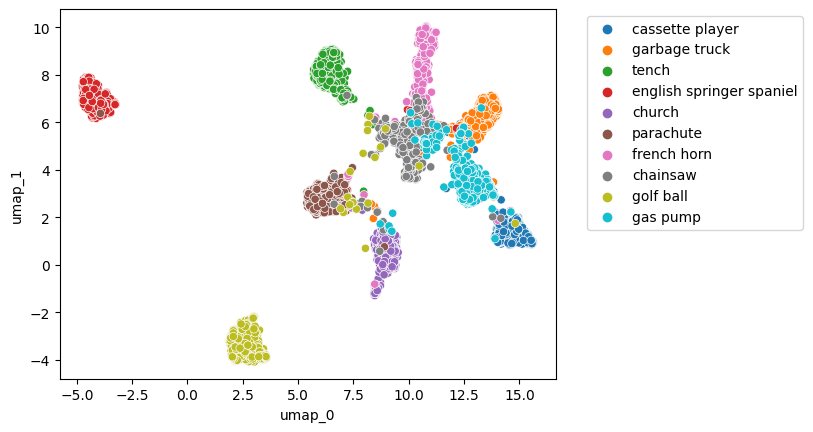

In [38]:
## OPTIONAL: this cell requires the seaborn dependency: https://seaborn.pydata.org/installing.html 
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=valid_df.to_pandas(), x="umap_0", y="umap_1", hue="label");
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

## 💾  Writing a `DataFrame` to disk. 
Finally, we can write the updated `DataFrame`, with all the activations and predictions included, to disk for later use.  

`DataFrame` size on disk: 25MB

On disk, the `DataFrame` is stored in a directory at the path passed to `DataFrame.write`. Within that directory, each column is stored separately. This allows us to read only a subset of columns from DataFrame on disk. Use the file explorer to the left to further expore the file structure of the `DataFrame`.  
```
valid_df
|  +-- meta.yml   
|  +-- state.dill  
|  +-- columns
   |   +-- activation
   |   +-- avg_blue
   |   +-- correct
   |   ...
   |   +-- umap_1
```


In [39]:
valid_df.write(os.path.join(dataset_dir, "valid_df"))

In [40]:
valid_df = mk.DataFrame.read(os.path.join(dataset_dir, "valid_df"))